# Project6 ATACSeq reference point signal calculation

By CAO Gaoxiang

2023-6-8

## steps
1. 读取BED文件，获得TSS；
2. 根据TSS，获得子区间；
3. 读取BAM文件，计算每个子区间的信号强度（基于项目4）；
4. 输出计算结果；
5. 读取结果，进行排序，画图。

In [19]:
import pysam

In [2]:
def multi_query_region_signal(
    signal_bam_obj,
    query_region_list,
    scale_method):
    """
    INPUT: 
        <signal_bam_obj>
            pysam AlignmentFile obj
            
        <query_region_list>
            list, each item contains three info, chrom, start, end 
            
        <scale_method>
            str, cpm, rpkm, raw
    RETURN:
        <signal_value_list>
            list, same length as input <query_region_list>
    """
    # count total
    total_count = 0

    for info in signal_bam_obj.get_index_statistics():
        total_count += info.mapped
    
    # query value
    signal_value_list = []
    
    for region_info in query_region_list:
        region_chr_name = region_info[0]
        region_start = int(region_info[1])
        region_end = int(region_info[2])

        region_count = 0
        
        for align in signal_bam_obj.fetch(contig=region_chr_name, start=region_start, end=region_end):
            region_count += 1
            
        if scale_method == "cpm":
            scale_value = region_count / 1.0 / (total_count / 1e6)
        elif scale_method == "rpkm":
            region_length = region_end - region_start
            scale_value = region_count / 1.0 / (total_count / 1e6) / (region_length / 1e3)
        elif scale_method == "raw":
            scale_value = region_count
        
        signal_value_list.append(round(scale_value, 6))
        
    return signal_value_list

In [3]:
# multi_query_region_signal(bam_file_obj, query_region_list, scale_method="cpm")

In [13]:
in_bed_file = open("./hg38_refseq_gene_TSS_TES_protein_only.chr21.bed")
# bam_file_obj = pysam.AlignmentFile("bam_files/293.ChIP.H3K4me3.rep1.ENCFF449FCR.bam", "r")
bam_file_obj = pysam.AlignmentFile("./bam_files/293.ChIP.H3K36me3.rep1.ENCFF899GOH.bam", "r")


split_num = 100
extend_length = 3000
extend_binsize =100

all_info_list = []


for region in in_bed_file:
    region_list = region.strip().split("\t")
    # print(region_list)
    
    chr_name = region_list[0]
    tss = int(region_list[1])
    tes =int(region_list[2])
    
    # make sub region
    upstream_region_list = []
    query_region_list = []
    downstream_region_list = []
       
    # upstream
    for up_region_start in range(tss - extend_length, tss, extend_binsize):
        up_region_end = min(up_region_start + extend_binsize, tss)
        
        upstream_region_list.append(
            [chr_name, up_region_start, up_region_end]
        )
   
    # downstream
    for down_region_start in range(tes, tes + extend_length, extend_binsize):
        down_region_end = min(down_region_start + extend_binsize, tes + extend_length)
        
        downstream_region_list.append(
            [chr_name, down_region_start, down_region_end]
        )
    
    # query region 
    step_size = (tes - tss) / 1.0 / split_num
    
    query_start = tss
    query_count = 0
    
    while query_start < tes:
        query_count += 1 
        
        query_end = min(int(query_start + step_size), tes)
        
        query_region_list.append(
        [chr_name, query_start, query_end]
        )
        
        query_start = query_end
        
        if query_count > split_num:
            break
    # get signal value 
    up_signal_val_list = multi_query_region_signal(
        signal_bam_obj=bam_file_obj, 
        query_region_list=upstream_region_list, 
        scale_method="rpkm"
    )
    
    query_signal_val_list = multi_query_region_signal(
    signal_bam_obj=bam_file_obj, 
    query_region_list=query_region_list, 
    scale_method="rpkm"
    )
    
    down_signal_val_list = multi_query_region_signal(
    signal_bam_obj=bam_file_obj, 
    query_region_list=downstream_region_list, 
    scale_method="rpkm"
    )
    
    # merge signal
    if region_list[5] == "+":
        merge_val_list = up_signal_val_list + query_signal_val_list + down_signal_val_list
    
    elif region_list[5] =="-":
        merge_val_list = down_signal_val_list[::-1] + query_signal_val_list[::-1] + up_signal_val_list[::-1]
        
    all_info_list.append(
        region_list + merge_val_list
    )


[W::hts_idx_load3] The index file is older than the data file: ./bam_files/293.ChIP.H3K36me3.rep1.ENCFF899GOH.bam.bai


In [14]:
# sort signal 
all_info_list_sort = sorted(all_info_list, key=lambda x: sum(x[6:]) / (len(x) - 6), reverse=True)

# signal_out_file = open("./signal_H3K4me3.ScaleRegion.csv", "wt")
signal_out_file = open("./signal_H3K36me3.ScaleRegion.csv", "wt")

# output header
header_list = ["chrom", "tss", "tes", "gene_id", "exon_num", "strand"]

value_header_list = [
    f"col{i}" for i in range(1, len(all_info_list_sort[0]) - 6 + 1)
]

out_header_list = header_list + value_header_list
out_header_str = ",".join(out_header_list)
signal_out_file.write(out_header_str + "\n")

# output value 
for signal_info in all_info_list_sort:
    out_str = ",".join(map(str, signal_info))
    signal_out_file.write(out_str + "\n")
    
signal_out_file.close()

In [6]:
import seaborn as sns
import pandas as pd 
import numpy as np 

In [15]:
# df = pd.read_csv("./signal_H3K4me3.ScaleRegion.csv")
df = pd.read_csv("./signal_H3K36me3.ScaleRegion.csv")
df

,chrom,tss,tes,gene_id,exon_num,strand,col1,col2,col3,col4,...,col152,col153,col154,col155,col156,col157,col158,col159,col160,col161
0,chr21,36070023,36073164,CBR1,3,+,0.000000,0.000000,0.000000,0.000000,...,0.979741,1.567585,2.155430,3.135170,0.979741,0.587844,0.979741,0.783793,1.175689,0.979741
1,chr21,39342314,39349088,HMGN1,6,-,0.195948,0.000000,0.000000,0.000000,...,0.391896,0.391896,0.391896,0.000000,0.000000,0.587844,0.587844,0.783793,0.979741,0.783793
2,chr21,26835754,26845409,ADAMTS1,9,-,0.000000,0.000000,0.000000,0.000000,...,0.391896,0.979741,0.783793,0.783793,0.195948,0.783793,0.587844,0.391896,1.371637,0.391896
3,chr21,33543037,33577481,SON,11,+,2.155430,2.743274,2.743274,3.135170,...,9.993355,6.270340,3.918963,2.351378,0.783793,0.979741,3.918963,2.939222,0.587844,0.391896
4,chr21,29056325,29073648,CCT8,16,-,0.000000,0.391896,0.195948,0.195948,...,2.939222,6.662237,6.270340,8.229822,8.033874,5.290600,5.682496,4.702755,5.682496,6.662237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,chr21,7769587,7770548,LOC102723451,1,-,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
222,chr21,7788702,7793939,LOC107983987,2,-,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
223,chr21,34400111,34401072,C21orf140,1,-,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
224,chr21,34418714,34423951,SMIM34,2,-,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


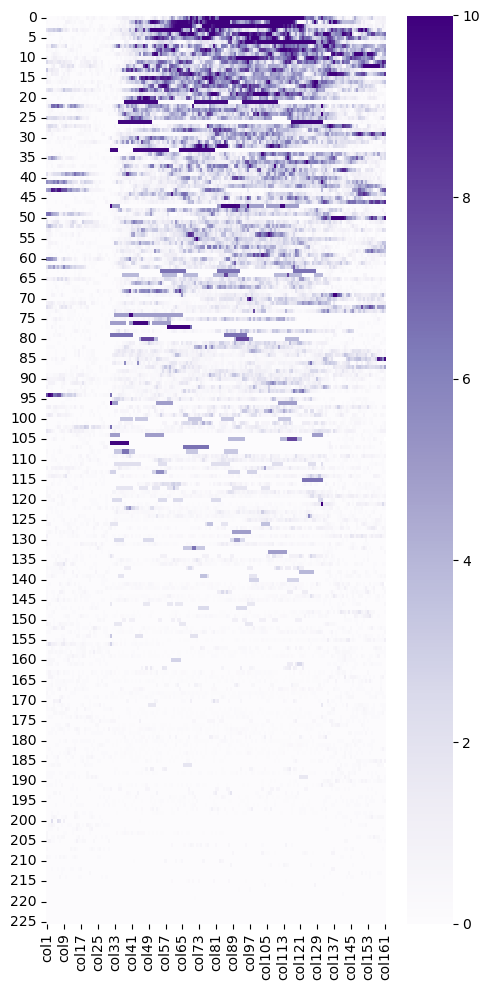

In [16]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [5, 10]
plt.rcParams["figure.autolayout"] = True

p1 = sns.heatmap(df.iloc[:, 6:167], vmin=0, vmax=10, cmap="Purples")
fig_p1 = p1.get_figure()
# fig_p1.savefig("./H3K4me3_heatmap.pdf", dpi=300)
fig_p1.savefig("./H3K36me3_heatmap.pdf", dpi=300)

In [17]:
a = df.iloc[:, 6:167].sum(0) / 161

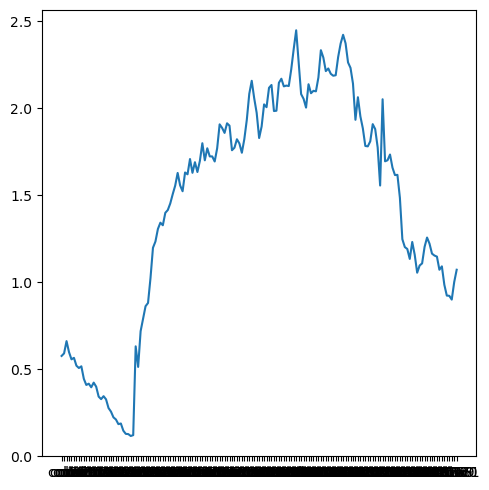

In [18]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True

p2 = sns.lineplot(a)
fig_p2 = p2.get_figure()
fig_p2.savefig("./H3K36me3_profile.pdf", dpi=300)